In [1]:
'''
Plasma donation induces a protein expression profile shift in circulating human blood
Rob Flickenger, October 31 2021
''' 
import json
import math

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from IPython.display import Markdown

In [2]:
# Slides were prepared in-house and laser scanned by RayBio.
#
# Pre-normalized CSV was generated from RayBio analysis tool .xlsx as 
# exported from Google Drive.

sample_norm = pd.read_csv(
    'plasma_data.csv', 
    encoding='utf8', 
    index_col='Protein'
)

In [3]:
# Convenience sample groups. See the end of this notebook for demographic breakdowns.

# All of the donors
donors = [
    ['A0', 'A1', 'A2'], 
    ['B0', 'B2'], 
    ['C0', 'C2', 'C3'], 
    ['D0', 'D2', 'D3']
]
flat_donors = [s for c in donors for s in c]

# Control samples (non-donor)
controls = ['E0', 'E1', 'E2']

# Circadian samples (three in one day, non-donor)
circadian = ['F0', 'F1', 'F2']

# All samples
all_samples = donors + [controls] + [circadian]
flat_all_samples = [s for c in all_samples for s in c]

In [4]:
# Clip to control -/+ per sample
for sample in flat_all_samples:
    sample_norm[sample] = sample_norm[sample].clip(
        lower=sample_norm[sample].loc['Neg'],
        upper=sample_norm[sample].loc['Positive Control']
    )

# Min-max per row
def normalize_per_row(the_df):
    normalized_per_row = the_df.copy().T

    for column in normalized_per_row.columns:
        col = normalized_per_row[column]
        normalized_per_row[column] = (col - col.min()) / (col.max() - col.min())

    return normalized_per_row.T

# Fold change from baseline to each successor
def calc_fold_change(samples):
    ''' Calculate the fold change +/- from a baseline of 1.0 '''    
    ds = pd.DataFrame()
    baseline = samples[0]
    ds[baseline] = (sample_norm[baseline] * 0) + 1.0 # Set to 1 but preserve index + row count
    
    for i, sample in enumerate(samples[1:]):
        ds[sample] = np.where(sample_norm[sample] > sample_norm[baseline], (sample_norm[sample] / sample_norm[baseline]), -(sample_norm[baseline] / sample_norm[sample]) )

    return ds.sort_values(samples[-1], ascending=True)

# Prepare several dataframes and groups for visualization.
folds = []
for sample in all_samples:
    folds.append(calc_fold_change(sample).T)
sample_fold = pd.concat(folds).T

# Min-max per sample
for sample in flat_all_samples:
    sample_norm[sample] = (sample_norm[sample] - sample_norm[sample].min()) / (sample_norm[sample].max() - sample_norm[sample].min())
    
# max_val column for easy sorting
sample_norm['max_val'] = sample_norm[flat_all_samples].T.max()

# This is the list of proteins measured in https://doi.org/10.18632/aging.103418 figure 5e
with open('./protein_groups.json') as f:
    protein_groups = json.load(f)

proteins = []
for g in protein_groups:
    proteins = proteins + [' ', f' {g}'] + protein_groups[g]
    
# Only the proteins of interest
tmp_df = sample_norm.T[[s for c in protein_groups.values() for s in c]]

# Protein as rows, Sample as columns, Value as values, ordered by group
proteins_by_group = tmp_df.T.reindex(proteins)



# Pre- vs. Post-donation change.
The change in expression after TPE shown in Figure 5E of [Rejuvenation of three germ layers tissues by 
exchanging old blood plasma with saline-albumin](https://doi.org/10.18632/aging.103418) is recreated here 
using data from the four plasma donors. Data is min/max normalized by row (protein) and samples are shown 
in all before / all after order for the original 53 proteins of interest.

While most proteins show a change after plasma donation similar to that observed after TPE in Mehdipour et al.,
the effect is not consistent across all proteins or all samples. A few (such as **Glut2**) even show
a negative correlation.


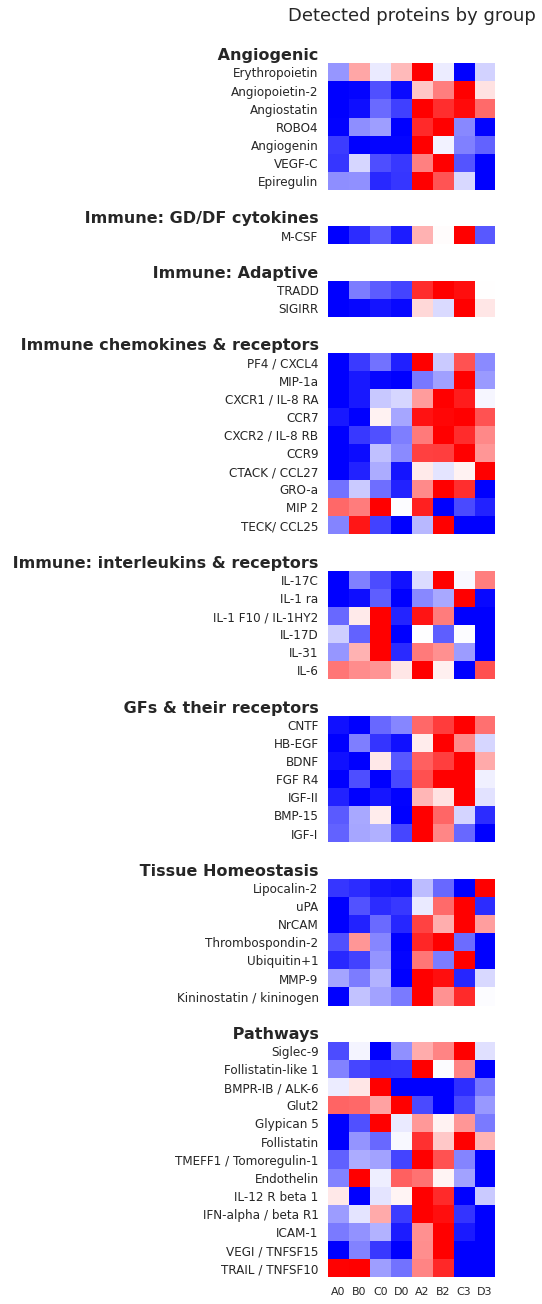

In [5]:
# Show only before and after donation, in before/after order
before_and_after = ['A0', 'B0', 'C0', 'D0', 'A2', 'B2', 'C3', 'D3']

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
fig = plt.figure(figsize=(3,len(proteins_by_group)/3))

ax = sns.heatmap(normalize_per_row(sample_norm[before_and_after]).reindex(proteins), annot=False, cbar=False, robust=False, cmap='bwr')

ax.set_title('Detected proteins by group', size=18)
ax.set(ylabel=None)
ax.tick_params(left=False)

for lab in ax.get_yticklabels():
    if lab.get_text().startswith(' '):
        lab.set_weight('bold')
        lab.set_size(16)
    else:
        lab.set_size(12)

display(Markdown('''
# Pre- vs. Post-donation change.
The change in expression after TPE shown in Figure 5E of [Rejuvenation of three germ layers tissues by 
exchanging old blood plasma with saline-albumin](https://doi.org/10.18632/aging.103418) is recreated here 
using data from the four plasma donors. Data is min/max normalized by row (protein) and samples are shown 
in all before / all after order for the original 53 proteins of interest.

While most proteins show a change after plasma donation similar to that observed after TPE in Mehdipour et al.,
the effect is not consistent across all proteins or all samples. A few (such as **Glut2**) even show
a negative correlation.
'''))

fig.show()

In [6]:
def show_heatmap(sample_group, title, top=507, robust=False, the_df=None, cmap="vlag"):
    if the_df is None:
        the_df = sample_norm.sort_values(by='max_val', ascending=False).head(top)        
    else:
        the_df = the_df.head(top)
        
    sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

    # Just one heatmap, dynamic range for all datapoints
    if isinstance(sample_group[0], str):
        fig = plt.figure(figsize=(len(sample_group),len(the_df) / 3))
        plt.title(f"{title}\n", size=18)
        sns.heatmap(the_df[sample_group], annot=False, robust=robust, cbar=False, yticklabels=True, cmap=cmap)
        ax = plt.gca()
        for lab in ax.get_yticklabels():
            if lab.get_text().startswith(' '):
                lab.set_weight('bold')
                lab.set_size(16)
            else:
                lab.set_size(12)
        ax.set(ylabel=None, xlabel=None)
        ax.tick_params(left=False)

    # Multiple heatmaps, dynamic range per column
    else:
        fig, axs = plt.subplots(ncols=len(sample_group), figsize=(len(sample_group) * 1.5,len(the_df) / 3))
        for i, s in enumerate(sample_group):
            # center the title
            if i == math.ceil(len(sample_group) / 2):
                ax.set_title(f"{title}\n", size=18)

            ax = sns.heatmap(the_df[s], annot=False, robust=robust, cbar=(i == len(all_samples) - 1), yticklabels=(i == 0), ax=axs[i], cmap=cmap)

            for lab in ax.get_yticklabels():
                if lab.get_text().startswith(' '):
                    lab.set_weight('bold')
                    lab.set_size(16)
                else:
                    lab.set_size(12)

            ax.set(ylabel=None, xlabel=None)
            ax.tick_params(left=False)

    fig.show()


# Protein concentrations over time

Relative protein concentrations are shown again, including intermediate donations. 
Each column represents a different participant, and cells within columns are colored blue-to-red 
(low-to-high) per sample. 

The first four columns show plasma donors. The first cell in each donor column shows the baseline 
concentration prior to donation. Rows that change from blue to red across each column indicate an increase 
concentration over time.

The final column shows samples from control participant **E** taken over the same period. The second cell
shows the highest concentration of many proteins, with no clear trend.

Participant demographics and donation schedules are provided at the end of this notebook.


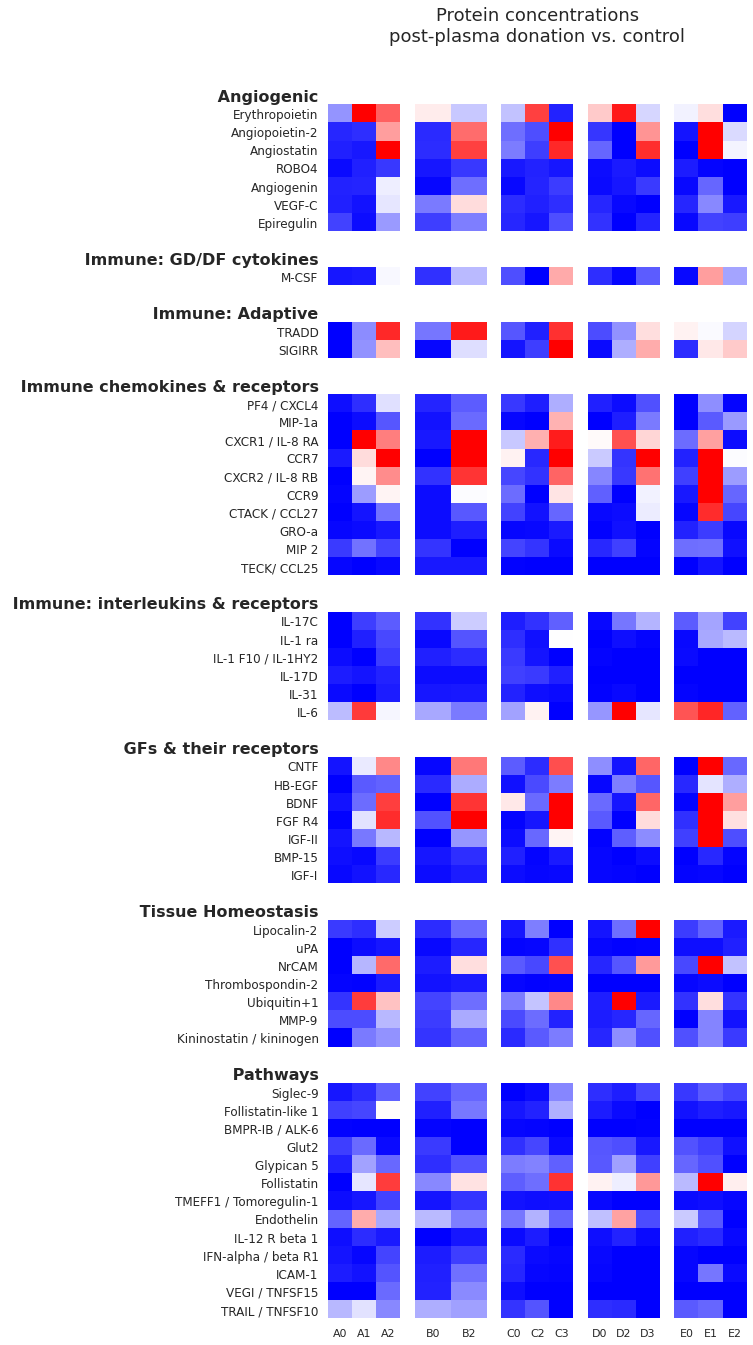

In [7]:
# Heatmap for donors and controls
display(Markdown('''
# Protein concentrations over time

Relative protein concentrations are shown again, including intermediate donations. 
Each column represents a different participant, and cells within columns are colored blue-to-red 
(low-to-high) per sample. 

The first four columns show plasma donors. The first cell in each donor column shows the baseline 
concentration prior to donation. Rows that change from blue to red across each column indicate an increase 
concentration over time.

The final column shows samples from control participant **E** taken over the same period. The second cell
shows the highest concentration of many proteins, with no clear trend.

Participant demographics and donation schedules are provided at the end of this notebook.
'''))
show_heatmap(donors + [controls], f"Protein concentrations\npost-plasma donation vs. control", robust=True, cmap="bwr", the_df=normalize_per_row(proteins_by_group))



# New proteins of interest
The antibody assay used for this experiment measures 507 proteins, many of which show a similar 
pattern of post-donation expression change. Here are the top 30 additional proteins that show an increase
in concentration after donation.


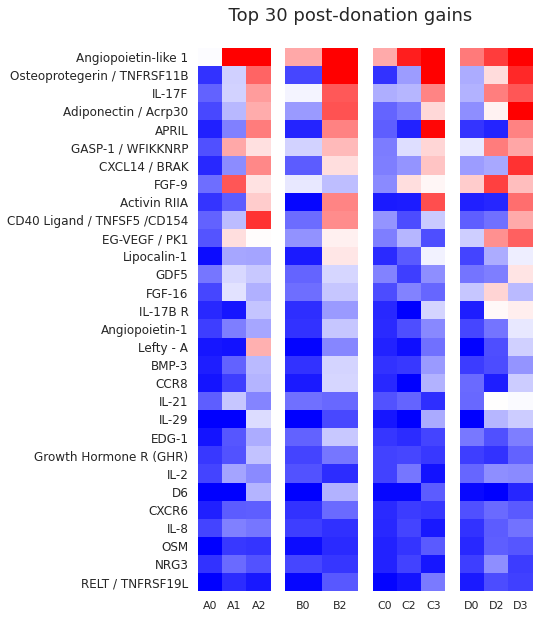

In [8]:
# Show all proteins not listed above, sorted by observed change.
top = 30

samples = donors
flat_samples = [s for c in samples for s in c]

# Shown above
proteins_of_interest = proteins_by_group.dropna().T.columns.to_list()

# Drop controls and proteins_of_interest
discard = ['Positive Control', 'Neg'] + proteins_of_interest

# Biggest gains
top_df = sample_norm[flat_samples].copy().drop(discard)

top_df['row_diff'] = top_df[['A2','B2','C3','D3']].T.sum() - top_df[['A0','B0','C0','D0']].T.sum()
top_df = top_df[top_df['row_diff'] > 0]
top_df['row_sum'] = top_df.T.sum()
top_df = top_df.sort_values('row_sum', ascending=False).head(top)

# Update proteins of interest 
proteins_of_interest = proteins_of_interest + top_df.T.columns.to_list()

# Biggest losses
bottom_df = sample_norm[flat_samples].copy().drop(discard)
bottom_df['row_diff'] = bottom_df[['A2','B2','C3','D3']].T.sum() - bottom_df[['A0','B0','C0','D0']].T.sum()
bottom_df = bottom_df[bottom_df['row_diff'] < 0]

bottom_df['row_sum'] = bottom_df.T.sum()
bottom_df = bottom_df.sort_values('row_sum', ascending=False).tail(top)

# Update proteins of interest 
proteins_of_interest = proteins_of_interest + bottom_df.T.columns.to_list()

display(Markdown(f'''
# New proteins of interest
The antibody assay used for this experiment measures 507 proteins, many of which show a similar 
pattern of post-donation expression change. Here are the top {top} additional proteins that show an increase
in concentration after donation.
'''))

show_heatmap(samples, f"          Top {top} post-donation gains", robust=True, the_df=top_df, cmap="bwr")


# All proteins of interest
This heatmap shows the top 30 proteins of interest, including those seen in Mehdipour et al.


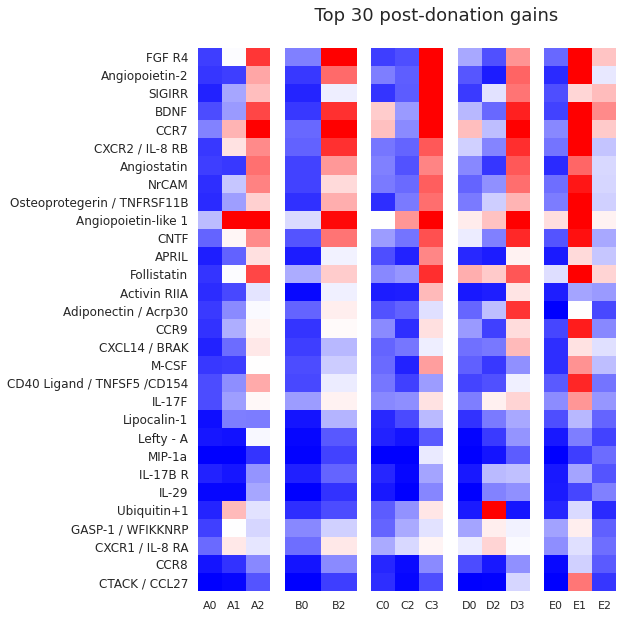

In [9]:
# Show all proteins included those listed above, sorted by observed change.
top = 30

samples = donors + [controls]
flat_samples = [s for c in samples for s in c]

display(Markdown(f'''
# All proteins of interest
This heatmap shows the top {top} proteins of interest, including those seen in Mehdipour et al.
'''))

# Drop controls and proteins_of_interest
discard = ['Positive Control', 'Neg'] 

# Biggest gains
all_df = sample_norm[flat_samples].copy().drop(discard)

all_df['row_diff'] = all_df[['A2','B2','C3','D3']].T.sum() - all_df[['A0','B0','C0','D0']].T.sum()
all_df = all_df[all_df['row_diff'] > 0]
all_df = all_df.sort_values('row_diff', ascending=False).head(top)

show_heatmap(samples, f"          Top {top} post-donation gains", robust=True, the_df=all_df, cmap="bwr")


# Change due to circadian variation
One person (participant **F**) provided blood test samples three times in a single day to measure the effect 
of circadian protein expression variation. Tests were performed in the early morning, afternoon, and late 
evening with approximately 7 hours between tests. This participant did not donate plasma.

This chart shows the fold increase or decrease compared to the morning baseline for all proteins of interest.


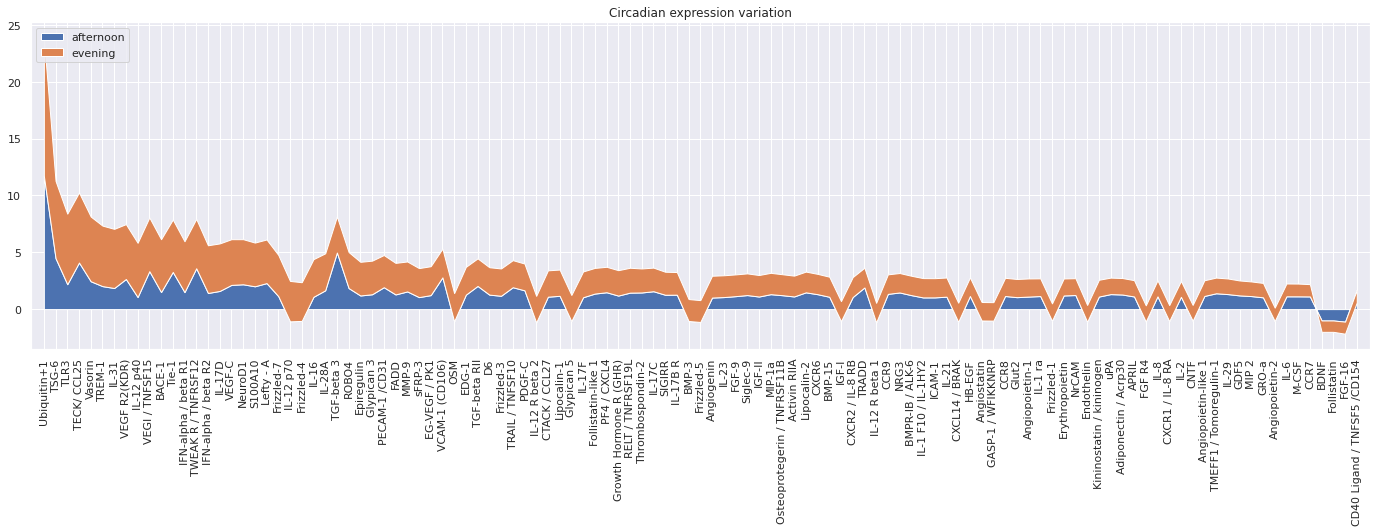

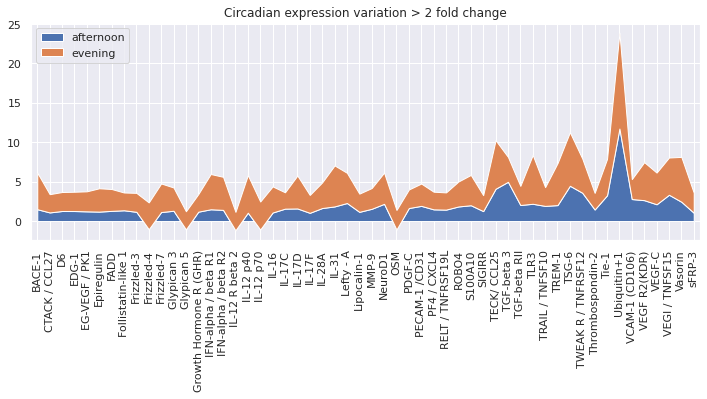

In [10]:
def show_fold_plot(the_df, title='', figsize=(24,6)):
    sns.set_theme('notebook')
    plt.figure(figsize=figsize)
    plt.stackplot(the_df.T.columns.to_list(), the_df['F1'], the_df['F2'])
    plt.xticks(rotation=90, ha='center')
    plt.legend(['afternoon','evening'], loc='upper left')
    ax = plt.gca()
    ax.margins(x=0.01)
    ax.set_title(title)
#     ax.get_yaxis().set_label_text('Fold change vs. morning baseline')
    plt.show()

display(Markdown('''
# Change due to circadian variation
One person (participant **F**) provided blood test samples three times in a single day to measure the effect 
of circadian protein expression variation. Tests were performed in the early morning, afternoon, and late 
evening with approximately 7 hours between tests. This participant did not donate plasma.

This chart shows the fold increase or decrease compared to the morning baseline for all proteins of interest.
'''))

# Fold plot sorted by final sample value
show_fold_plot(
    sample_fold[circadian].T[proteins_of_interest].T.sort_values(['F2'], ascending=False),
    'Circadian expression variation'
)

# Same again, sorted alphabetically, fold change > 2
the_df = sample_fold[circadian].T[proteins_of_interest].T.sort_index()
show_fold_plot(
    the_df[the_df['F2'] > 2.0],
    'Circadian expression variation > 2 fold change',
    figsize=(12,4)
)



# Expected circadian variation

With the exception of participant **F**, all plasma tests were performed in the early afternoon. 
While the time awake was not carefully controlled for every participant, the median rate of change 
from afternoon to evening in the circadian experiment was approximately **0.27**
fold per hour. Even allowing for a few hours variance in time awake between donors, this is well below 
the observed fold change for the top proteins of interest.


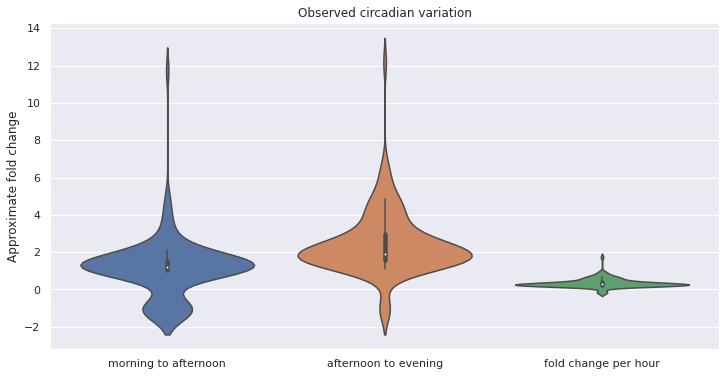

In [11]:
# Expected change per hour due to circadian effects

the_df = sample_fold[circadian[1:]].T[proteins_of_interest].T
the_df['diff'] = (the_df['F2']) / 7.0 # Seven hours between tests

plt.figure(figsize=(12,6))
ax = sns.violinplot(data=the_df, scale='width')
ax.margins(x=0.05)
ax.set_title("Observed circadian variation")
ax.set_xticklabels(['morning to afternoon', 'afternoon to evening', 'fold change per hour'])
ax.set(xlabel=None, ylabel="Approximate fold change")

display(Markdown(f'''
# Expected circadian variation

With the exception of participant **F**, all plasma tests were performed in the early afternoon. 
While the time awake was not carefully controlled for every participant, the median rate of change 
from afternoon to evening in the circadian experiment was approximately **{the_df['diff'].median():0.2}**
fold per hour. Even allowing for a few hours variance in time awake between donors, this is well below 
the observed fold change for the top proteins of interest.
'''))

plt.show()


In [12]:
# Show the top post-donation gains and losses 
top = 35
ymax = 20
ymin = -20

post_donation = ['A1', 'A2', 'B2', 'C2', 'C3', 'D2', 'D3']

dfs = []
tmp_df = sample_fold.loc[proteins_of_interest].reset_index()
for sample in post_donation:
    bp = pd.DataFrame()
    bp['Protein'] = tmp_df['Protein']
    bp['Value'] = tmp_df[sample]
    bp['Sample'] = sample
    dfs.append(bp)
    
bp = pd.concat(dfs).reset_index()

for protein in proteins_of_interest:
    bp.loc[bp['Protein'] == protein, 'Median'] = bp[bp['Protein'] == protein]['Value'].median()
    
bp['Value'] = bp['Value'].clip(lower=ymin, upper=ymax)

In [13]:
# Remove losses
too_cold = set(bp[bp['Value'] < 0]['Protein'])

bp = bp[~bp['Protein'].isin(too_cold)]

print(f"Removed {len(too_cold)} outlier proteins")


Removed 93 outlier proteins


In [14]:
# Find the top protein names
protein_order = {}
for p in bp.sort_values(['Median'], ascending=False)['Protein']:
    protein_order[p] = 0
    
top_proteins = list(protein_order.keys())[:top]


# Top protein gains

After discarding outliers, the top 20 protein gains show a median fold increase of **2.3**. 


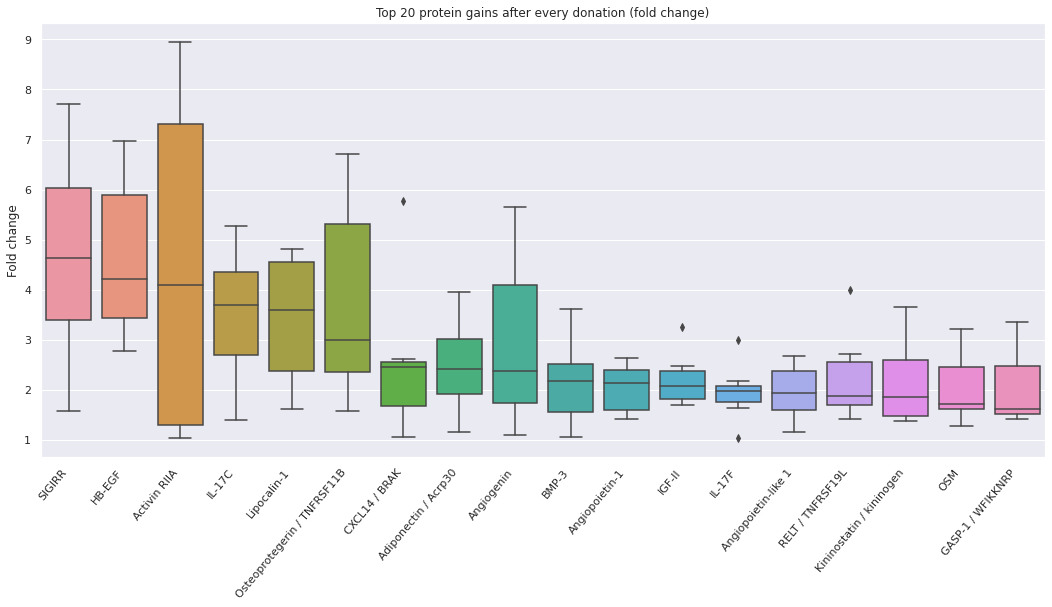

In [15]:
# The threshold of significance for this array is a fold increase of at least 1.6
# or a decrease of at least 0.6.

def show_box_plot(the_df, title=""):
    plt.figure(figsize=(18,8))
    ax = sns.boxplot(x="Protein", y="Value", data=the_df, )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
    ax.set_title(title)
    ax.set(xlabel=None, ylabel="Fold change")
    plt.show()

# Sort and filter < minimum significant change
top_df = bp[bp['Protein'].isin(top_proteins)].sort_values('Median', ascending=False)
top_df = top_df[top_df['Median'] >= 1.6]

display(Markdown(f'''
# Top protein gains

After discarding outliers, the top {len(top_proteins)} protein gains show a median fold increase of **{top_df['Median'].median():0.2}**. 
'''))

show_box_plot(top_df, title=f"Top {len(top_proteins)} protein gains after every donation (fold change)")


# Participant demographics
|Sample|Sex|Age|Notes|
|:----:|:-:|:-:|:----|
|A|M|34|Donor (Monthly)|
|B|F|37|Donor (Monthly)|
|C|F|41|Donor (Sporadic)|
|D|M|46|Donor (1-2 weeks between donations)|
|E|M|34|Control|
|F|M|46|Control (circadian)|

# Donor schedule and test intervals
Donors were tested approximately 5 days after each plasma donation.

|Sample|Donation #|Donation interval|
|:----:|:--------:|:-------|
|A0|0|Pre-donation|
|A1|1|Initial donation|
|A2|2|33 days after A1|
|B0|0|Pre-donation|
|(B1)|1|Initial donation (not tested)|
|B2|2|27 days after B1|
|C0|0|Pre-donation|
|(C1)|1|Initial donation (not tested)|
|C2|2|17 days after C1|
|C3|3|57 days after C2|
|D0|0|Pre-donation|
|(D1)|1|Initial donation (not tested)|
|D2|2|17 days after D1|
|D3|3|7 days after D2|

Control E was tested approximately once per month. 

Control F was tested three times in a single day (early morning, afternoon, late evening) with approximately 7 hours between tests.